In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact

from scipy.stats import spearmanr, pearsonr, kruskal
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import procrustes
from skbio.stats.distance import mantel, permanova, DistanceMatrix
from skbio.stats.ordination import pcoa

from statsmodels.stats.multitest import fdrcorrection
import statsmodels.formula.api as smf
%matplotlib inline
sns.set_style("ticks")

In [2]:
metabo = pd.read_csv("data/Metabolome_BF.csv", encoding='unicode_escape')

metabo = metabo[metabo["Sample"].isna()==False]
metabo = metabo.drop(["Sample Description", "Sample Weight", "Date and Time"], axis=1)

metabo = metabo.set_index("Sample")

#Clean up column names
metabo.columns = [" ".join(col.split(" ")[:-4]) for col in list(metabo.columns)]

#Impute NQ as LLOQ/2
metabo.replace(to_replace="NQ",
               value=np.nan,
               inplace=True)

metabo.loc["LLOQ",:] = metabo.loc["LLOQ",:].astype(float)
metabo.loc["half LLOQ",:] = metabo.loc["LLOQ"]/2
metabo.iloc[2:-1,:] = metabo.iloc[2:-1,:].fillna(metabo.loc["half LLOQ",:])

#Drop ULOQ/LLOQ
metabo.drop(["half LLOQ","LLOQ","ULOQ"], inplace=True)

In [3]:
metabo.head()

,myristic acid (14:0),myristoleic acid (14:1n5),pentadecanoic acid (15:0),palmitic acid (16:0),palmitoleic acid (16:1n7),margaric acid (17:0),stearic acid (18:0),oleic acid (18:1n9),vaccenic acid (18:1n7),linoleic acid (18:2n6),...,eicosapentaenoic acid (20:5n3),behenic acid (22:0),erucic acid (22:1n9),cis-13-16-docosadienoic acid (22:2n6),adrenic acid (22:4n6),osbond acid (22:5n6),docosapentaenoic acid (22:5n3),docosahexaenoic acid (22:6n3),lignoceric acid (24:0),nervonic acid (24:1n9)
Sample,,,,,,,,,,,,,,,,,,,,,
B.F 1.1,0.601,0.48,0.408,10.5,0.8,0.385,3.81,3.09,0.8,6.4,...,0.8,0.793,0.112,0.48,0.48,0.48,0.8,1.6,0.878,0.8
B.F 1.2,4.990,0.282,4.770,50.7,1.51,2.560,11.80,14.00,3.82,6.84,...,0.8,3.000,0.476,0.308,0.48,0.48,0.8,1.6,6.410,1.97
B.F 1.3,8.810,0.491,7.540,106.0,2.35,4.420,30.20,40.90,8.11,8.64,...,0.8,3.300,0.848,0.785,1.31,0.48,2.16,2.86,7.800,2.52
B.F 2.1,6.250,0.131,4.510,93.8,2.36,2.420,17.20,29.50,5.53,13.7,...,0.8,2.100,0.582,0.379,0.793,0.973,1.51,3.08,4.650,1.39
B.F 2.2,7.310,0.165,4.960,111.0,2.50,2.860,22.80,36.80,6.49,15.0,...,0.8,2.680,0.608,0.425,0.946,0.48,0.8,4.44,6.510,1.99


In [4]:
metadata = pd.read_csv("data/metadata.tsv", sep="\t", index_col="Sampleid")
metadata = metadata.reindex(metabo.index)

In [5]:
for var in metabo.columns:
    metabo[var] = metabo[var].astype(float)

## Correlations with time

In [6]:
spear_time_volc = pd.DataFrame(index=metabo.columns, columns=["p","r"])

for lipid in metabo.columns:
    spear = spearmanr(metabo[lipid],
                      metadata["Timepoint"])
    
    spear_time_volc.loc[lipid, "p"] = spear.pvalue
    
    spear_time_volc.loc[lipid, "r"] = spear.correlation
    
spear_time_volc["-log10 p value"] = spear_time_volc["p"].apply(lambda x: -1*np.log10(x))

In [7]:
spear_time_volc = spear_time_volc.sort_values(by="p")
spear_time_volc["fdr_p"] = fdrcorrection(spear_time_volc["p"])[1]
spear_time_volc["fdr_sig"] = fdrcorrection(spear_time_volc["p"])[0]
spear_time_volc["significant"] = spear_time_volc["p"] < 0.05 
spear_time_volc.loc[spear_time_volc["p"]<0.05,"significance type"] = "p < 0.05"
spear_time_volc.loc[spear_time_volc["p"]>0.05,"significance type"] = "p > 0.05"
spear_time_volc.loc[spear_time_volc["fdr_p"]<0.05,"significance type"] = "FDR p < 0.05"


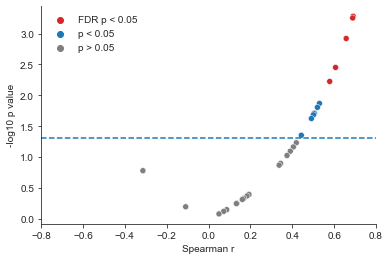

In [8]:
ax = sns.scatterplot(y="-log10 p value",x="r", 
                     hue="significance type",
                     palette=["tab:red", "tab:blue", "tab:grey"],
                     data=spear_time_volc)

ax.axhline(-np.log10(0.05), ls="--")
ax.set(xlim=(-0.8,0.8), xlabel="Spearman r")

ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)

plt.savefig("Figures/Volcano_time_lipids.png")
plt.savefig("Figures/Volcano_time_lipids.pdf")

plt.show()

In [9]:
spear_time_volc.reset_index()

,index,p,r,-log10 p value,fdr_p,fdr_sig,significant,significance type
0,cis-11-eicosaenoic acid (20:1n9),0.000525,0.690894,3.279873,0.008401,True,True,FDR p < 0.05
1,"cis-11,14-eicosadienoic acid (20:2n6)",0.00056,0.688423,3.251752,0.008401,True,True,FDR p < 0.05
2,alpha-linolenic acid (18:3n3),0.001203,0.657368,2.919715,0.012031,True,True,FDR p < 0.05
3,myristic acid (14:0),0.003539,0.60678,2.451069,0.026546,True,True,FDR p < 0.05
4,adrenic acid (22:4n6),0.005968,0.578877,2.224140,0.035811,True,True,FDR p < 0.05
5,stearic acid (18:0),0.01352,0.529728,1.869030,0.062233,False,True,p < 0.05
6,oleic acid (18:1n9),0.015656,0.520097,1.805320,0.062233,False,True,p < 0.05
7,linoleic acid (18:2n6),0.019317,0.505814,1.714052,0.062233,False,True,p < 0.05
8,cis-13-16-docosadienoic acid (22:2n6),0.019794,0.504118,1.703462,0.062233,False,True,p < 0.05
9,erucic acid (22:1n9),0.020744,0.500834,1.683099,0.062233,False,True,p < 0.05


/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/64053053.py:24: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/64053053.py:24: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/64053053.py:25: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("Figures/metabolite_spearman_p.pdf")
/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/64053053.py:25: Matplot

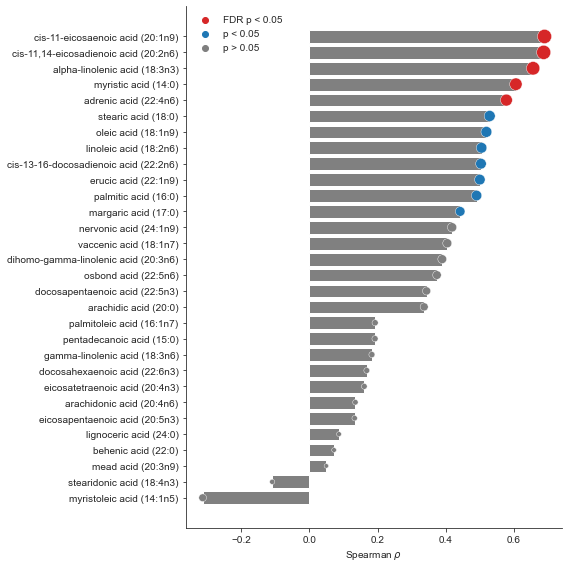

In [10]:
ax = sns.barplot(x="r", 
                 y="index",
                 palette=["grey"],
                 data=spear_time_volc.reset_index().sort_values(by="r", ascending=False))


sns.scatterplot(x="r", 
                y="index",
                hue="significance type",
                size="-log10 p value", sizes=(20,200),
                palette=["tab:red", "tab:blue", "tab:grey"],
                data=spear_time_volc.reset_index().sort_values(by="r", ascending=False),
                ax=ax)


handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[1:4],labels[1:4],
          frameon=False)
ax.set(xlabel=r"Spearman $\rho$", ylabel=None)

ax.spines[["top", "right"]].set_visible(False)
plt.gcf().set_size_inches(8,8)

plt.tight_layout()
plt.savefig("Figures/metabolite_spearman_p.pdf")
plt.savefig("Figures/metabolite_spearman_p.png")
plt.show()

In [11]:
spear_time_volc.loc[spear_time_volc["p"]<0.05].sort_values(by="p")

,p,r,-log10 p value,fdr_p,fdr_sig,significant,significance type
cis-11-eicosaenoic acid (20:1n9),0.000525,0.690894,3.279873,0.008401,True,True,FDR p < 0.05
"cis-11,14-eicosadienoic acid (20:2n6)",0.00056,0.688423,3.251752,0.008401,True,True,FDR p < 0.05
alpha-linolenic acid (18:3n3),0.001203,0.657368,2.919715,0.012031,True,True,FDR p < 0.05
myristic acid (14:0),0.003539,0.60678,2.451069,0.026546,True,True,FDR p < 0.05
adrenic acid (22:4n6),0.005968,0.578877,2.224140,0.035811,True,True,FDR p < 0.05
stearic acid (18:0),0.01352,0.529728,1.869030,0.062233,False,True,p < 0.05
oleic acid (18:1n9),0.015656,0.520097,1.805320,0.062233,False,True,p < 0.05
linoleic acid (18:2n6),0.019317,0.505814,1.714052,0.062233,False,True,p < 0.05
cis-13-16-docosadienoic acid (22:2n6),0.019794,0.504118,1.703462,0.062233,False,True,p < 0.05
erucic acid (22:1n9),0.020744,0.500834,1.683099,0.062233,False,True,p < 0.05


In [12]:
spear_time_volc_for_paper = spear_time_volc.loc[spear_time_volc["p"]<0.05, ["p","fdr_p", "r"]]
spear_time_volc_for_paper.columns = ["p", "FDR p", "Spearman rho"]
# spear_time_volc_for_paper.to_csv("sig_lipids_time.csv")

In [13]:
sig_lipids_df = pd.concat([metabo[spear_time_volc_for_paper.index],
                           metadata[["Timepoint", "Subjectcode"]]
                          ],
                          axis=1
                         )
sig_lipids_df = sig_lipids_df.rename(columns = {"Subjectcode": "Participant"})

melted_sig_lipids_df = pd.melt(sig_lipids_df, id_vars=["Timepoint", "Participant"])

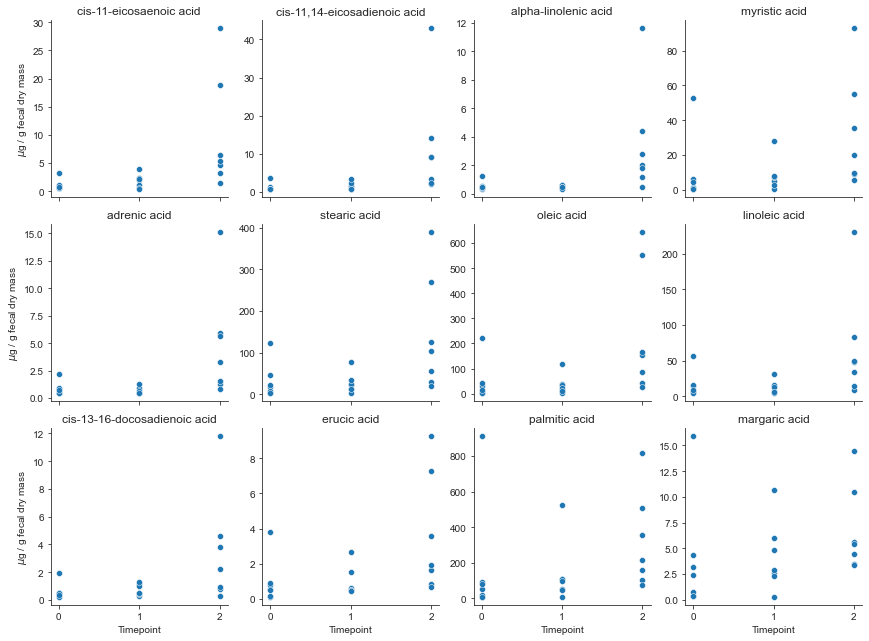

In [14]:
g = sns.FacetGrid(melted_sig_lipids_df, col="variable", col_wrap=4, sharey=False)

g.map(sns.scatterplot, "Timepoint", "value")

for ax in g.axes:
    ax_title = ax.get_title()
    ax.set(xticks=[0,1,2],
           title=ax_title.split("= ")[1].split(" (")[0])
g.set_ylabels(r"$\mu$g / g fecal dry mass")


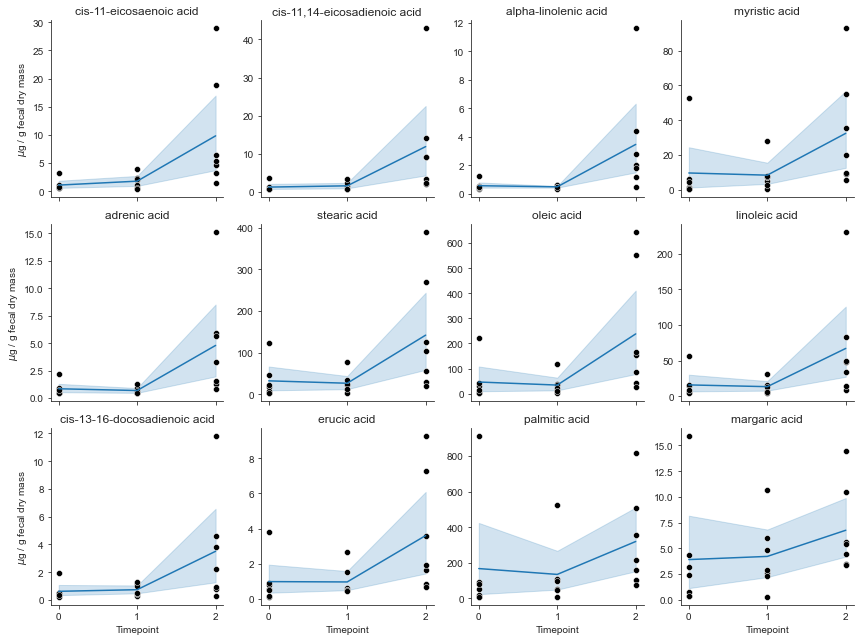

In [15]:
g = sns.FacetGrid(melted_sig_lipids_df, col="variable", col_wrap=4, sharey=False)

g.map(sns.lineplot, "Timepoint", "value")
g.map(sns.scatterplot, "Timepoint", "value", color=["black"])

for ax in g.axes:
    ax_title = ax.get_title()
    ax.set(xticks=[0,1,2],
           title=ax_title.split("= ")[1].split(" (")[0])
g.set_ylabels(r"$\mu$g / g fecal dry mass")

plt.savefig("Figures/sig_time_lipids_line_ci_scatter.png")
plt.savefig("Figures/sig_time_lipids_line_ci_scatter.pdf")
plt.show()

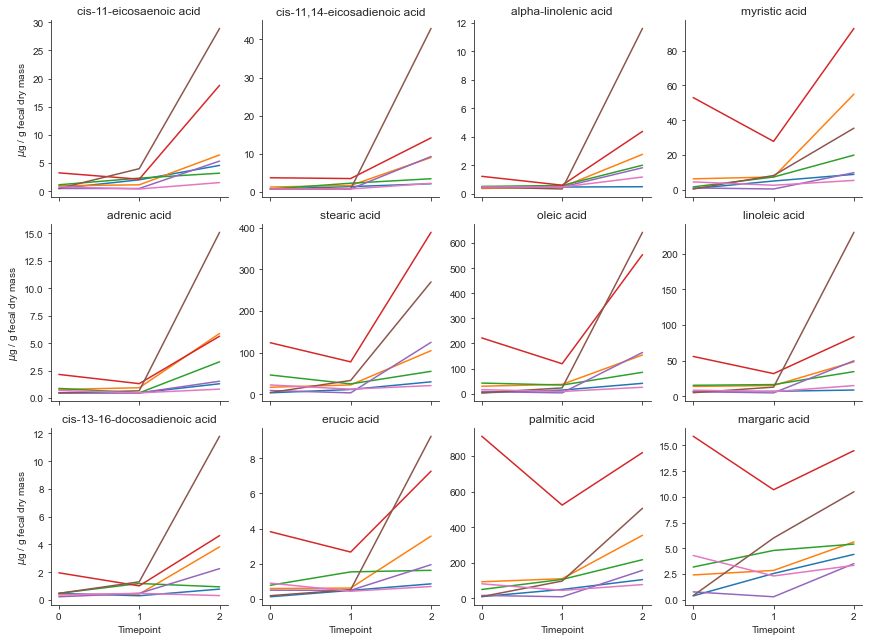

In [16]:
g = sns.FacetGrid(melted_sig_lipids_df, col="variable", col_wrap=4, sharey=False)

g.map(sns.lineplot, "Timepoint", "value", "Participant")

for ax in g.axes:
    ax_title = ax.get_title()
    ax.set(xticks=[0,1,2],
           title=ax_title.split("= ")[1].split(" (")[0])
g.set_ylabels(r"$\mu$g / g fecal dry mass")

/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


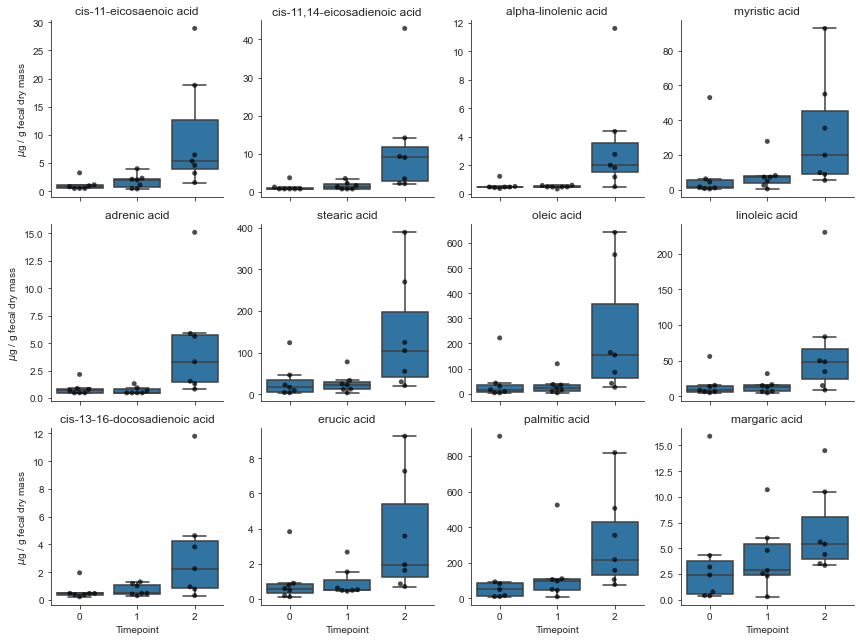

In [17]:
g = sns.FacetGrid(melted_sig_lipids_df, col="variable", col_wrap=4, sharey=False)

g.map(sns.boxplot, "Timepoint", "value", order=[0,1,2], showfliers=False)
g.map(sns.swarmplot, "Timepoint", "value", palette=["black"], alpha=0.7)

for ax in g.axes:
    ax_title = ax.get_title()
    ax.set(xticks=[0,1,2],
           title=ax_title.split("= ")[1].split(" (")[0])
g.set_ylabels(r"$\mu$g / g fecal dry mass")

plt.savefig("Figures/sig_time_lipids_boxplot.png")
plt.savefig("Figures/sig_time_lipids_boxplot.pdf")
plt.show()

### Mixed effects models

In [18]:
lme_df = pd.concat([metabo, metadata[["Timepoint", "Subjectcode"]]],
                   axis=1)

# log transform all lipids
for lipid in lme_df.drop(["Timepoint", "Subjectcode"], axis=1).columns:
    lme_df[lipid] = lme_df[lipid].apply(np.log10)

In [19]:
lipid_lme_mapper = {x: x.replace(" ","_").replace("-","_").replace(",","_").split("(")[0] for x in metabo.columns}
lme_df.rename(columns=lipid_lme_mapper,
             inplace=True)

In [20]:
lme_time_volc = pd.DataFrame(index=lme_df.drop(["Timepoint", "Subjectcode"], axis=1).columns, 
                             columns=["p","beta"])

for lipid in lme_df.drop(["Timepoint", "Subjectcode"], axis=1).columns:
    lme = smf.mixedlm(f"{lipid} ~ Timepoint", 
                      lme_df, 
                      groups=lme_df["Subjectcode"]).fit()
    
    lme_time_volc.loc[lipid, "p"] = lme.pvalues["Timepoint"]
    
    lme_time_volc.loc[lipid, "beta"] = lme.params["Timepoint"]
    
lme_time_volc["-log10 p value"] = lme_time_volc["p"].apply(lambda x: -1*np.log10(x))

/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-

In [21]:
lme_time_volc = lme_time_volc.sort_values(by="p")
lme_time_volc["fdr_p"] = fdrcorrection(lme_time_volc["p"])[1]
lme_time_volc["fdr_sig"] = fdrcorrection(lme_time_volc["p"])[0]
lme_time_volc["significant"] = lme_time_volc["p"] < 0.05 
lme_time_volc.loc[lme_time_volc["p"]<0.05,"significance type"] = "p < 0.05"
lme_time_volc.loc[lme_time_volc["p"]>0.05,"significance type"] = "p > 0.05"
lme_time_volc.loc[lme_time_volc["fdr_p"]<0.05,"significance type"] = "FDR p < 0.05"


In [22]:
lme_time_volc.rename(index={v:k for k,v in lipid_lme_mapper.items()}, inplace=True)

/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/1532388487.py:24: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/1532388487.py:24: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/1532388487.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("Figures/lme_sig_time_lipids_beta.png")
/var/folders/wp/9dsg4hm50lg540x82g1bht1r0000gn/T/ipykernel_61695/1532388487.py:

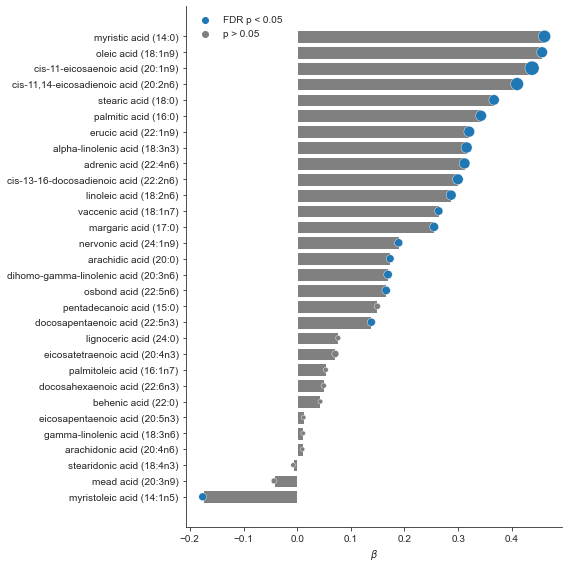

In [23]:
ax = sns.barplot(x="beta", 
                 y="index",
                 palette=["grey"],
                 data=lme_time_volc.reset_index().sort_values(by="beta", ascending=False))


sns.scatterplot(x="beta", 
                y="index",
                hue="significance type",
                size="-log10 p value", sizes=(20,200),
                palette=["tab:blue", "tab:grey"],
                data=lme_time_volc.reset_index().sort_values(by="beta", ascending=False),
                ax=ax)


handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[1:3],labels[1:3],
          frameon=False)
ax.set(xlabel=r"$\beta$", ylabel=None)

ax.spines[["top", "right"]].set_visible(False)
plt.gcf().set_size_inches(8,8)

plt.tight_layout()

plt.savefig("Figures/lme_sig_time_lipids_beta.png")
plt.savefig("Figures/lme_sig_time_lipids_beta.pdf")

plt.show()

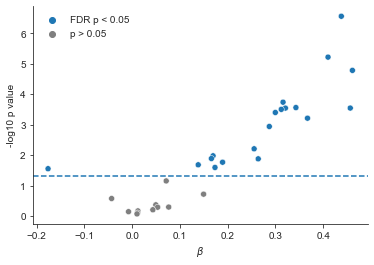

In [24]:
ax = sns.scatterplot(y="-log10 p value",x="beta", 
                     hue="significance type",
                     palette=["tab:blue", "tab:grey"],
                     data=lme_time_volc)

ax.axhline(-np.log10(0.05), ls="--")
ax.set(xlabel=r"$\beta$")

ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)

plt.savefig("Figures/lme_volcano_time.png")
plt.savefig("Figures/lme_volcano_time.pdf")

plt.show()

In [25]:
lme_time_volc_for_paper = lme_time_volc.loc[lme_time_volc["p"]<0.05, ["p","fdr_p", "beta"]]
lme_time_volc_for_paper.columns = ["lme", "FDR p", "Spearman rho"]
lme_time_volc_for_paper.to_csv("sig_lipids_time.csv")

In [26]:
sig_lipids_df = pd.concat([metabo[lme_time_volc_for_paper.index],
                           metadata[["Timepoint", "Subjectcode"]]
                          ],
                          axis=1
                         )
sig_lipids_df = sig_lipids_df.rename(columns = {"Subjectcode": "Participant"})

melted_sig_lipids_df = pd.melt(sig_lipids_df, id_vars=["Timepoint", "Participant"])

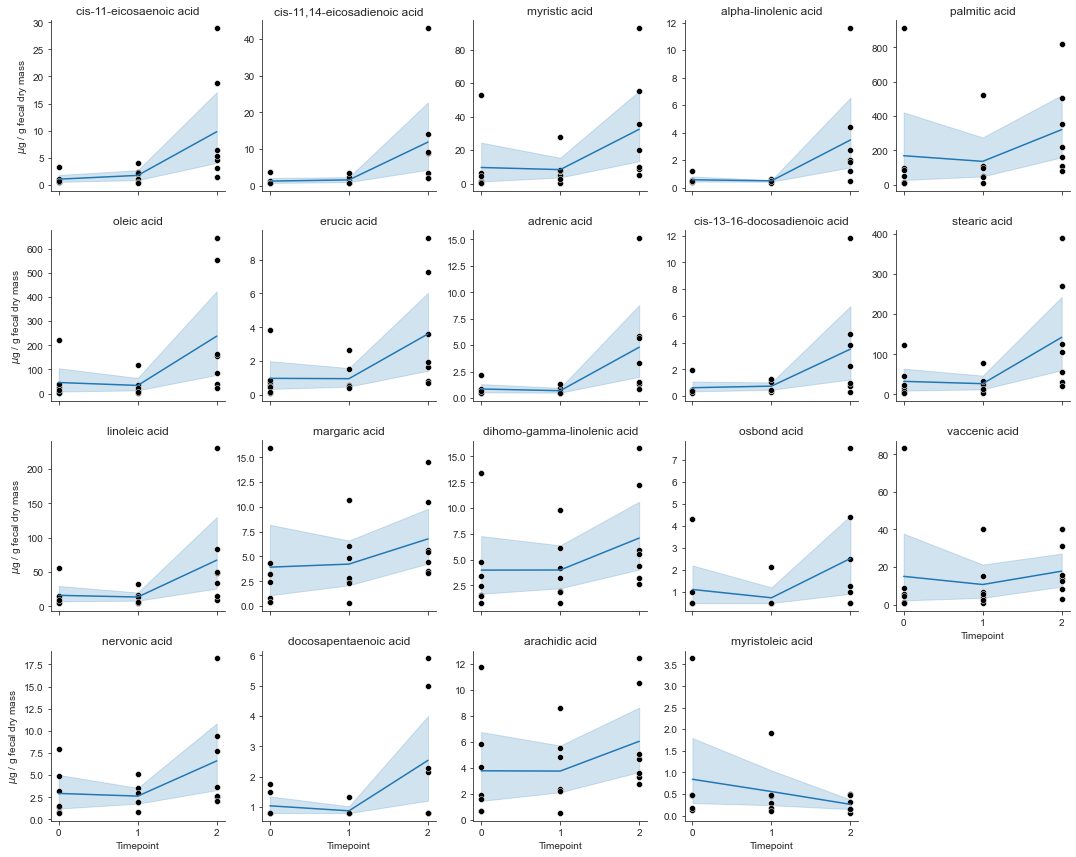

In [27]:
g = sns.FacetGrid(melted_sig_lipids_df, col="variable", col_wrap=5, sharey=False)

g.map(sns.lineplot, "Timepoint", "value")
g.map(sns.scatterplot, "Timepoint", "value", color=["black"])

for ax in g.axes:
    ax_title = ax.get_title()
    ax.set(xticks=[0,1,2],
           title=ax_title.split("= ")[1].split(" (")[0])
g.set_ylabels(r"$\mu$g / g fecal dry mass")

plt.savefig("Figures/sig_time_lipids_line_ci_scatter.png")
plt.savefig("Figures/sig_time_lipids_line_ci_scatter.pdf")
plt.show()

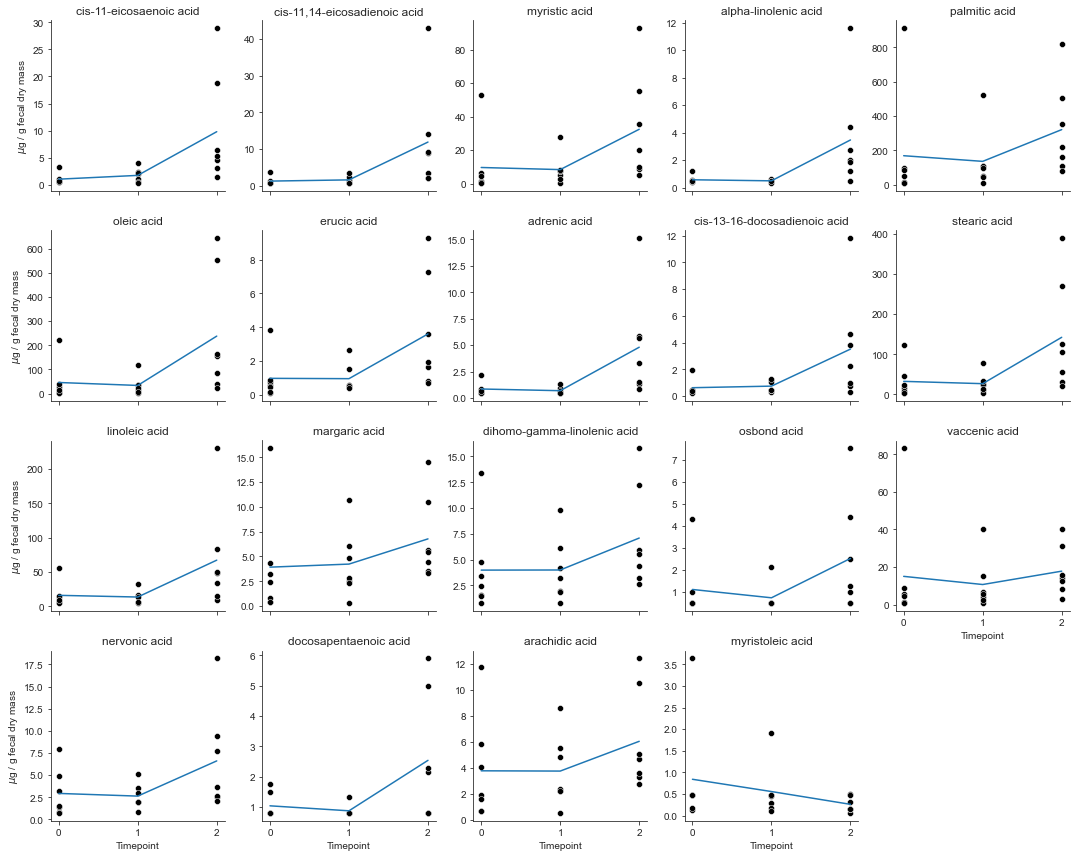

In [28]:
g = sns.FacetGrid(melted_sig_lipids_df, col="variable", col_wrap=5, sharey=False)

g.map(sns.lineplot, "Timepoint", "value", ci=None)
g.map(sns.scatterplot, "Timepoint", "value", color=["black"])

for ax in g.axes:
    ax_title = ax.get_title()
    ax.set(xticks=[0,1,2],
           title=ax_title.split("= ")[1].split(" (")[0])
g.set_ylabels(r"$\mu$g / g fecal dry mass")

plt.savefig("Figures/sig_time_lipids_line_scatter.png")
plt.savefig("Figures/sig_time_lipids_line_scatter.pdf")
plt.show()

# Ordinations, Mantel, and PERMANOVA

In [29]:
metabo_braycurt = DistanceMatrix(squareform(pdist(metabo, metric="braycurtis")), ids=metabo.index)

In [30]:
metabo_pcoa = pcoa(metabo_braycurt, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01399391442838006 and the largest is 2.1598307072968215.
  warn(


In [31]:
metabo_pcoa.proportion_explained

PC1    0.584448
PC2    0.287275
PC3    0.044437
dtype: float64

### Participant

In [32]:
metadata["Participant"] = metadata["Subjectcode"]

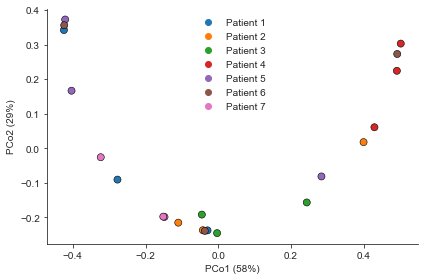

In [33]:
ax = sns.scatterplot(x="PC1", y="PC2", hue=metadata["Participant"], 
                     data=metabo_pcoa.samples,
                     s=50, edgecolor="black")

ax.set(xlabel="PCo1 (58%)", ylabel="PCo2 (29%)") #based on proportion explained in cell above

ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)

plt.tight_layout()
plt.savefig("Figures/participant_metabo_pcoa.png")
plt.savefig("Figures/participant_metabo_pcoa.pdf")
plt.show()

In [34]:
metabo_braycurt = DistanceMatrix(squareform(pdist(metabo, metric="braycurtis")), ids=metabo.index)

permanova(metabo_braycurt, metadata["Subjectcode"])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      21
number of groups                  7
test statistic             2.105091
p-value                       0.038
number of permutations          999
Name: PERMANOVA results, dtype: object

previously:

>method name               PERMANOVA \
test statistic name        pseudo-F \
sample size                      21 \
number of groups                  7 \
test statistic             0.577544 \
p-value                       0.888 \
number of permutations          999 \
Name: PERMANOVA results, dtype: object

### Timepoint

In [35]:
#initialize empty distance matrix
dat = metadata["Timepoint"].dropna()
dim = dat.shape[0]
distm = np.empty((dim, dim))

#fill distance matrix
for i in range(dim):
    for j in range(dim):
        distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

distm = DistanceMatrix(distm, ids=dat.index)

#filter where we don't have data
microbiome_distm = DistanceMatrix(metabo_braycurt.to_data_frame().loc[dat.index,dat.index], 
                          ids=dat.index)
#do the mantel
man = mantel(microbiome_distm, 
            distm,
            method="spearman")

print("MANTEL TIMEPOINT METABOLOME")
print(f"p value: {man[1]}")
print(f"pseudo-F: {man[0]}")

MANTEL TIMEPOINT METABOLOME
p value: 0.025
pseudo-F: 0.16546399581077356


previously:

>MANTEL TIMEPOINT METABOLOME \
p value: 0.034 \
pseudo-F: 0.16546399581077356

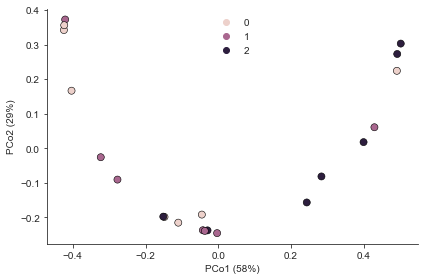

In [36]:
ax = sns.scatterplot(x="PC1", y="PC2", hue=metadata["Timepoint"], 
                     data=metabo_pcoa.samples,
                     s=50, edgecolor="black")

ax.set(xlabel="PCo1 (58%)", ylabel="PCo2 (29%)") #based on proportion explained in cell above

ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False, loc=9)

plt.tight_layout()
plt.savefig("Figures/time_metabo_pcoa.png")
plt.savefig("Figures/time_metabo_pcoa.pdf")
plt.show()

In [37]:
wuni = Artifact.load("core-diversity-results/weighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

wuni_pcoa = pcoa(wuni, number_of_dimensions=3)
wuni_pcoa.proportion_explained


/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.4061327428976467 and the largest is 9.013033150347638.
  warn(


PC1    0.349151
PC2    0.252022
PC3    0.130317
dtype: float64

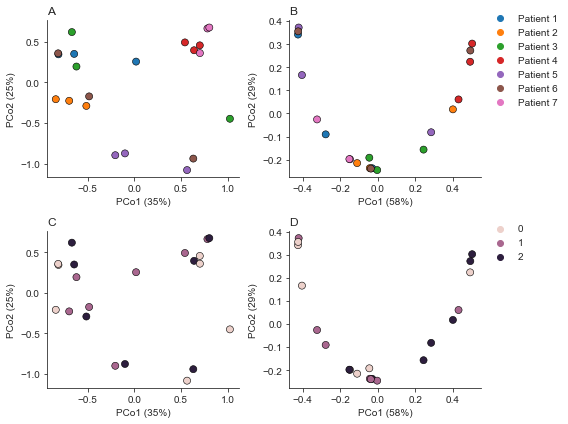

In [38]:
fig, axes = plt.subplots(2,2, figsize=(8,6))

# Microbiome by participant
sns.scatterplot(x="PC1", y="PC2", hue=metadata["Participant"], 
                     data=wuni_pcoa.samples,
                     s=50, edgecolor="black",
                     ax=axes[0,0], legend=False)

axes[0,0].set(xlabel="PCo1 (35%)", ylabel="PCo2 (25%)") #based on proportion explained in cell above
axes[0,0].set_title("A", loc="left")
axes[0,0].spines[["right", "top"]].set_visible(False)
#axes[0,0].legend(frameon=False, bbox_to_anchor=(1,1.1),)


# metabo by participant
sns.scatterplot(x="PC1", y="PC2", hue=metadata["Participant"], 
                     data=metabo_pcoa.samples,
                     s=50, edgecolor="black",
                     ax=axes[0,1])

axes[0,1].set(xlabel="PCo1 (58%)", ylabel="PCo2 (29%)") #based on proportion explained in cell above
axes[0,1].set_title("B", loc="left")
axes[0,1].spines[["right", "top"]].set_visible(False)
axes[0,1].legend(frameon=False, bbox_to_anchor=(1,1.1))


# Microbiome by time

sns.scatterplot(x="PC1", y="PC2", hue=metadata["Timepoint"], 
                data=wuni_pcoa.samples,
                s=50, edgecolor="black",
                ax=axes[1,0], legend=False)

axes[1,0].set(xlabel="PCo1 (35%)", ylabel="PCo2 (25%)") #based on proportion explained in cell above
axes[1,0].set_title("C", loc="left")
axes[1,0].spines[["right", "top"]].set_visible(False)


# metabo by time

sns.scatterplot(x="PC1", y="PC2", hue=metadata["Timepoint"], 
                data=metabo_pcoa.samples,
                s=50, edgecolor="black",
                ax=axes[1,1])

axes[1,1].set(xlabel="PCo1 (58%)", ylabel="PCo2 (29%)") #based on proportion explained in cell above
axes[1,1].set_title("D", loc="left")
axes[1,1].spines[["right", "top"]].set_visible(False)
axes[1,1].legend(frameon=False, bbox_to_anchor=(1,1.1))

plt.tight_layout()
plt.savefig("Figures/all_pcoa.png")
plt.savefig("Figures/all_pcoa.pdf")
plt.show()

# Stacked Barplot

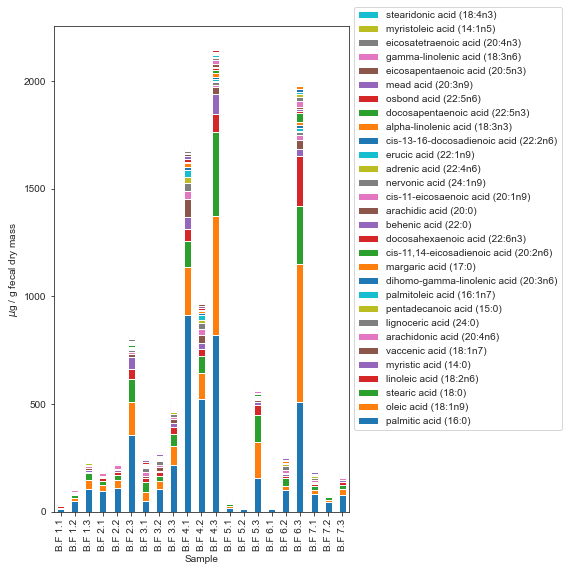

In [39]:
s = metabo.sum(axis=0)
ax = metabo[s.sort_values(ascending=False).index].plot(kind="bar", stacked=True)

#reverse the order of legend contents so it corresponds with the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1.05))

ax.set_ylabel(r"$\mu$g / g fecal dry mass")
plt.gcf().set_size_inches(8,8)

plt.tight_layout()
plt.savefig("Figures/metabo_stacked_bar.png")
plt.savefig("Figures/metabo_stacked_bar.pdf")
plt.show()

In [40]:
pearsonr(metabo.sum(axis=1),
          metadata["Timepoint"])

(0.36765545049500126, 0.1010761270238276)

<AxesSubplot:xlabel='Timepoint'>

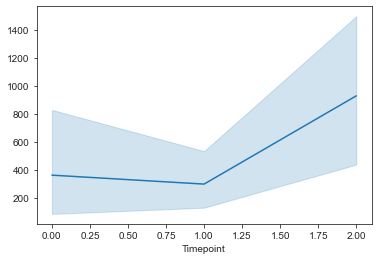

In [41]:
sns.lineplot(y=metabo.sum(axis=1),
             x=metadata["Timepoint"])

# Saturated vs unsaturated

In [42]:
saturated = []
unsaturated = []

for col in metabo.columns:
    if col.split(":")[-1]=="0)":
        saturated.append(col)
    else:
        unsaturated.append(col)

In [43]:
metabo["Saturated FA total"] = metabo[saturated].sum(axis=1)
metabo["Unsaturated FA total"] = metabo[unsaturated].sum(axis=1)

<AxesSubplot:>

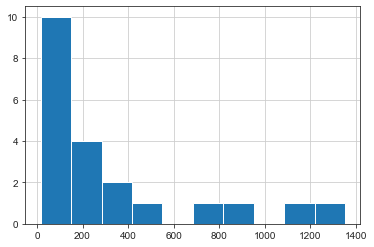

In [44]:
metabo["Saturated FA total"].hist()

<AxesSubplot:>

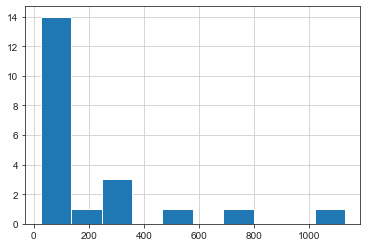

In [45]:
metabo["Unsaturated FA total"].hist()

In [46]:
spearmanr(metabo["Saturated FA total"],
          metadata["Timepoint"])

SpearmanrResult(correlation=0.491202756937505, pvalue=0.023743115999134926)

In [47]:
spearmanr(metabo["Unsaturated FA total"],
          metadata["Timepoint"])

SpearmanrResult(correlation=0.491202756937505, pvalue=0.023743115999134926)

In [48]:
pearsonr(metabo["Saturated FA total"],
          metadata["Timepoint"])

(0.3080552929266184, 0.17428682695855147)

In [49]:
pearsonr(metabo["Unsaturated FA total"],
          metadata["Timepoint"])

(0.41659444710070404, 0.06029648144703889)

<AxesSubplot:xlabel='Timepoint', ylabel='Saturated FA total'>

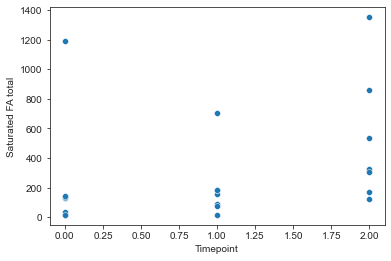

In [50]:
sns.scatterplot(y=metabo["Saturated FA total"],
                x=metadata["Timepoint"])

<AxesSubplot:xlabel='Timepoint', ylabel='Unsaturated FA total'>

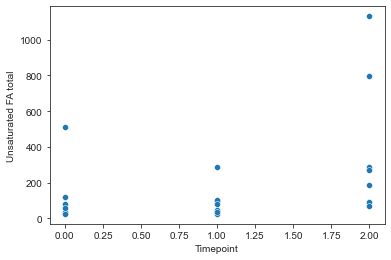

In [51]:
sns.scatterplot(y=metabo["Unsaturated FA total"],
                x=metadata["Timepoint"])

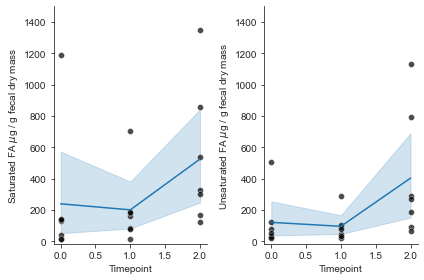

In [52]:
fig,axes = plt.subplots(nrows=1,ncols=2)

sns.lineplot(y=metabo["Saturated FA total"],
                 x=metadata["Timepoint"],
                 palette=["tab:blue"],
                 ax=axes[0])

sns.scatterplot(y=metabo["Saturated FA total"],
                   x=metadata["Timepoint"],
                   color=["black"], alpha=0.7,
                   ax=axes[0])



sns.lineplot(y=metabo["Unsaturated FA total"],
                 x=metadata["Timepoint"],
                 palette=["tab:blue"],
                 ax=axes[1])

sns.scatterplot(y=metabo["Unsaturated FA total"],
                   x=metadata["Timepoint"],
                   color=["black"], alpha=0.7,
                   ax=axes[1])

axes[0].set(ylabel=r"Saturated FA $\mu$g / g fecal dry mass",
            ylim=(-15,1500))
axes[1].set(ylabel=r"Unsaturated FA $\mu$g / g fecal dry mass",
            ylim=(-15,1500))

axes[0].spines[["right", "top"]].set_visible(False)
axes[1].spines[["right", "top"]].set_visible(False)

plt.tight_layout()

plt.savefig("Figures/Saturated_unsat_linescatter.png")
plt.savefig("Figures/Saturated_unsat_linescatter.pdf")
plt.show()

In [54]:
sat_lme = pd.concat([metabo[["Saturated FA total", "Unsaturated FA total"]],
                     metadata[["Timepoint", "Participant"]]
                     ],
                    axis=1)
sat_lme.rename(columns={"Saturated FA total": "Saturated_FA_total",
                        "Unsaturated FA total": "Unsaturated_FA_total"},
               inplace=True)
print(
    smf.mixedlm("Saturated_FA_total ~ Timepoint",
            data=sat_lme,
            groups=sat_lme["Participant"]).fit().summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Saturated_FA_total
No. Observations: 21      Method:             REML              
No. Groups:       7       Scale:              40641.5875        
Min. group size:  3       Log-Likelihood:     -137.2044         
Max. group size:  3       Converged:          Yes               
Mean group size:  3.0                                           
-----------------------------------------------------------------
               Coef.     Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept       179.776   142.387  1.263  0.207  -99.298  458.849
Timepoint       142.649    53.879  2.648  0.008   37.048  248.251
Group Var    108050.870   421.002                                



In [55]:
print(
    smf.mixedlm("Unsaturated_FA_total ~ Timepoint",
            data=sat_lme,
            groups=sat_lme["Participant"]).fit().summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Unsaturated_FA_total
No. Observations: 21      Method:             REML                
No. Groups:       7       Scale:              53699.6662          
Min. group size:  3       Log-Likelihood:     -135.2857           
Max. group size:  3       Converged:          Yes                 
Mean group size:  3.0                                             
-------------------------------------------------------------------
                 Coef.    Std.Err.    z    P>|z|   [0.025    0.975]
-------------------------------------------------------------------
Intercept         66.396    94.055  0.706  0.480  -117.948  250.741
Timepoint        141.213    61.933  2.280  0.023    19.827  262.599
Group Var      17174.848   105.650                                 



In [56]:
sat_lme["Total_FA"] = sat_lme["Saturated_FA_total"] + sat_lme["Unsaturated_FA_total"]

print(
    smf.mixedlm("Total_FA ~ Timepoint",
            data=sat_lme,
            groups=sat_lme["Participant"]).fit().summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Total_FA   
No. Observations:  21      Method:             REML       
No. Groups:        7       Scale:              177229.6219
Min. group size:   3       Log-Likelihood:     -149.2027  
Max. group size:   3       Converged:          Yes        
Mean group size:   3.0                                    
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    246.172  227.280 1.083 0.279 -199.288 691.632
Timepoint    283.862  112.513 2.523 0.012   63.340 504.384
Group Var 213900.992  452.588                             



# Procrustes

In [57]:
tax_braycurt = Artifact.load("core-diversity-results/bray_curtis_distance_matrix.qza").view(DistanceMatrix)

In [58]:
tax_pcoa_coords = pd.DataFrame(pcoa(tax_braycurt).samples)[["PC1","PC2","PC3"]]
tax_pcoa_coords.index = list(tax_braycurt.ids)

metabo_pcoa_coords = pd.DataFrame(pcoa(metabo_braycurt).samples)[["PC1","PC2","PC3"]]
metabo_pcoa_coords.index = metabo.index

/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.012102740189118007 and the largest is 1.6333975100184703.
  warn(
/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the No

In [59]:
mtx1, mtx2, disparity = procrustes(metabo_pcoa_coords,
                                   tax_pcoa_coords)
print(f'disparity: {disparity}')

disparity: 0.906653576249191


In [60]:
proplot = pd.concat([pd.DataFrame(mtx1),
                     pd.DataFrame(mtx2)])
proplot.columns = ["PC1","PC2","PC3"]
proplot["Dataset"] = ["microbiome"]*mtx1.shape[0] + ["metabolome"]*mtx2.shape[0]

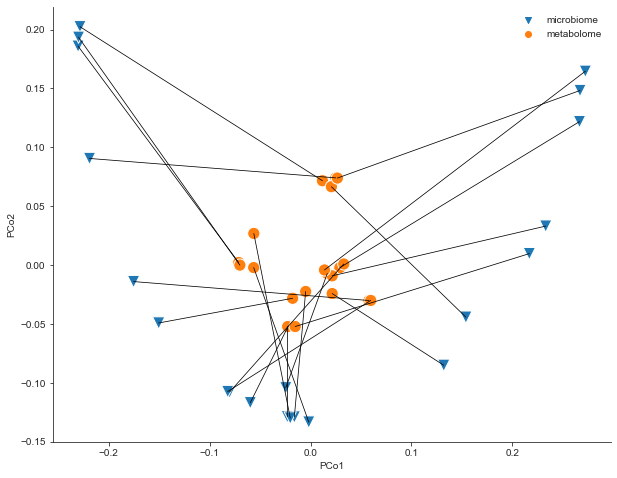

In [61]:
ax = sns.scatterplot(x="PC1",y="PC2",
                     style="Dataset",hue="Dataset",
                     data=proplot,
                     markers=["v","o"],
                     s=150)

for i in range(len(mtx1)):
    plt.plot([mtx1[i,0],mtx2[i,0]],
             [mtx1[i,1],mtx2[i,1]],
             c="black", linewidth=0.75)
    
plt.gcf().set_size_inches(10,8)
#ax.set_title("Procrustes-transformed Bray-Curtis PCoA of Microbiome and Metabolome", fontsize="large")

ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False)
ax.set(xlabel="PCo1", ylabel="PCo2")

plt.savefig("Figures/Procrustes.png")
plt.savefig("Figures/Procrustes.pdf")

plt.show()

In [62]:
rows, cols = metabo.shape
n=10000

disparities = []
for x in range(n):
    metabo_rand = metabo_pcoa_coords.sample(frac=1,axis=0).reset_index(drop=True)
    
    mtx1_rand, mtx2_rand, disparity_rand = procrustes(metabo_rand, tax_pcoa_coords)
    disparities.append(disparity_rand)

pval = (sum([disparity > d for d in disparities])+1)/(n+1)

print(f'Procrustean randomization test pval: {pval}')

Procrustean randomization test pval: 0.4570542945705429


Text(0, 0.5, 'Occurrences during 10,000 permutations')

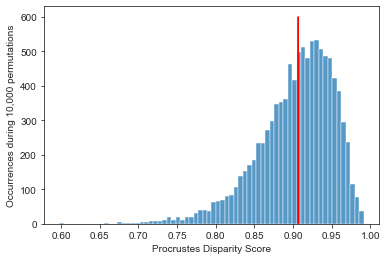

In [63]:
ax = sns.histplot(disparities)
ax.arrow(disparity,0,
         0,600,
         width=0.0001,
         color="red") 
ax.set_xlabel("Procrustes Disparity Score")
ax.set_ylabel("Occurrences during 10,000 permutations")
